Reference:

[1] https://github.com/learnables/learn2learn/blob/master/examples/text/news_topic_classification.py

In [1]:
# !pip install fairseq --user
# !pip install learn2learn --user

### Meta Learning MAML for Abuse Detection in Tweets [implemented through learn2learn library]

learn2learn is a software library for meta-learning research. It is built on top of PyTorch to accelerate two aspects of the meta-learning research cycle:

1. fast prototyping, essential in letting researchers quickly try new ideas, and
2. correct reproducibility, ensuring that these ideas are evaluated fairly.

MAML is a Model-Agnostic Meta-Learning Algorithm proposed in https://arxiv.org/pdf/1703.03400.pdf

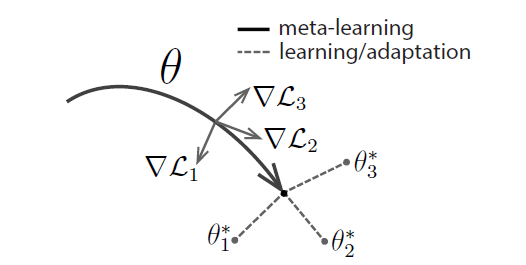

### Import Libraries

In [2]:
import argparse
import random

import pandas as pd
import numpy as np

import torch
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaModel

import learn2learn as l2l

### Load Data

In [3]:
BASE = 'C:\\Users\\basharm\\OneDrive - Queensland University of Technology\\JupyterPythonQUT\\StandardDataSets\\QMI\\'

C:\Users\basharm\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
train = 'train.csv'
test = 'test.csv'

In [5]:
df_train = pd.read_csv(BASE+train)
df_train.head(5)

,label,text
0,1,"@ nbcnews a blowhard , ignorant reality tv sho..."
1,0,@ biushydolan listen 😔 im not a whore for whit...
2,0,kyle scrolls bye my photo on insta and goes “ ...
3,0,"due to few evil-doers , 65 crore male populati..."
4,1,@ dloesch @ maryemcglynn @ alyssa_milano @ hea...


In [6]:
df_train.groupby('label').count()

C:\Users\basharm\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text
label,
0,2572
1,1439


In [7]:
# We apply only this preprocessing because our data is already preprocessed
def cleanNonAscii(text):
    return ''.join(i for i in text if ord(i) < 128)

C:\Users\basharm\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
df_train['text'] = df_train['text'].apply(cleanNonAscii)

In [9]:
X_train, y_train = df_train['text'].values, df_train['label'].values

In [10]:
df_test = pd.read_csv(BASE+test)
df_test.head()

,label,text
0,1,@ winegirl73 2 bit attention seeking whore
1,0, i was dodging bullets in slow motion you slut 
2,0,@ mayoroflondon sadiq khan-proud mayor of the ...
3,0,"@ lewdpon3 i agree , you should definitely lea..."
4,1,@ peoples_pundit @ fluffydogattack @ sengillib...


In [11]:
df_test['text'] = df_test['text'].apply(cleanNonAscii)

C:\Users\basharm\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
X_test, y_test = df_test['text'].values, df_test['label'].values

In [13]:
X_train[0], X_test[0]

('@ nbcnews a blowhard , ignorant reality tv show host and his porn whore russian wife . perfect .',
 '@ winegirl73 2 bit attention seeking whore')

### Prepare Data

##### Tokenize text and pad sequences

In [14]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

num_words = 100000

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

C:\Users\basharm\AppData\Roaming\Python\Python38\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\basharm\AppData\Roaming\Python\Python38\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Users\basharm\AppData\Roaming\Python\Python38\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from gener

In [15]:
tokenizer.texts_to_sequences(["physics is nice"])

[[7533, 10, 317]]

In [16]:
tokenizer.texts_to_sequences(["physics is nice"])

[[7533, 10, 317]]

In [17]:
tokenizer.sequences_to_texts([[7533, 10, 317]])

['physics is nice']

In [18]:
xtrain = tokenizer.texts_to_sequences(X_train)
maxlen = max(map(lambda x: len(x),xtrain))
xtrain = pad_sequences(xtrain, maxlen=maxlen)

xtest = tokenizer.texts_to_sequences(X_test)
xtest = pad_sequences(xtest, maxlen=maxlen)

In [19]:
xtrain.shape, xtest.shape

((4011, 54), (1003, 54))

In [20]:
xtrain[0][40:]

array([   2, 2970,  259, 1064,  480,  260, 2971,    8,   89,  332,    1,
        446,  229,  527])

### Define Model

In [21]:
device = 'cpu'

In [22]:
class Net(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, num_classes, input_dim=54, inner_dim=200, pooler_dropout=0.3):
        super().__init__()
        self.dense = nn.Linear(input_dim, inner_dim)
        self.activation_fn = nn.ReLU()
        self.dropout = nn.Dropout(p=pooler_dropout)
        self.out_proj = nn.Linear(inner_dim, num_classes)

    def forward(self, x, **kwargs):
        #x = self.dropout(x)
        x = self.dense(x)
        x = self.activation_fn(x)
        x = self.dropout(x)
        x = F.log_softmax(self.out_proj(x), dim=1)
        return x
    
model = Net(2)
model.to(device)

Net(
  (dense): Linear(in_features=54, out_features=200, bias=True)
  (activation_fn): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (out_proj): Linear(in_features=200, out_features=2, bias=True)
)

### Define Accuracy Calculation Function

In [23]:
def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1)
    acc = (predictions == targets).sum().float()
    acc /= len(targets)
    return acc.item()

### Define Utilisty Function

In [24]:
class _BatchedDataset(torch.utils.data.Dataset):
    def __init__(self, xbatch, ybatch):
        self.xbatch = xbatch
        self.ybatch = ybatch
    
    def __len__(self):
        return len(self.ybatch)
    
    def __getitem__(self, idx):
        return (self.xbatch[idx], self.ybatch[idx])

In [25]:
# xtask = xtrain
# ytask = y_train
# torch.utils.data.DataLoader(_BatchedDataset(xtask, ytask), batch_size=5, shuffle=True, num_workers=0)

In [26]:
def compute_loss(task, device, learner, loss_func, batch=10):
    loss = 0.0
    acc = 0.0
    xtask, ytask = task
    for i, (x, y) in enumerate(torch.utils.data.DataLoader(
            _BatchedDataset(xtask, ytask), batch_size=batch, shuffle=True, num_workers=0)):
        
        # Moving to device
        x = x.to(torch.float32)
        x, y = x.to(device), y.view(-1).to(device)

        output = learner(x) # learner is the classification model
        curr_loss = loss_func(output, y)
        acc += accuracy(output, y)
        loss += curr_loss / len(ytask)
    loss /= len(ytask)
    return loss, acc

### Prepare Datasets

In [27]:
dataset = l2l.data.MetaDataset(_BatchedDataset(xtrain, y_train))
classes = list(range(len(dataset.labels))) # 41 classes
random.shuffle(classes)

In [28]:
train_dataset, validation_dataset, test_dataset = dataset, dataset, dataset

In [29]:
ways = 2
shots = 100

transforms = [
    l2l.data.transforms.NWays(train_dataset, n=ways),
    l2l.data.transforms.KShots(train_dataset, k=shots),
    l2l.data.transforms.LoadData(train_dataset),
]
train_gen = l2l.data.TaskDataset(train_dataset, transforms, num_tasks=len(xtrain)/shots)

In [30]:
transforms = [
    l2l.data.transforms.NWays(validation_dataset, n=ways),
    l2l.data.transforms.KShots(validation_dataset, k=shots),
    l2l.data.transforms.LoadData(validation_dataset),
]
valid_gen = l2l.data.TaskDataset(validation_dataset, transforms, num_tasks=len(xtrain)/shots)

In [31]:
transforms = [
    l2l.data.transforms.NWays(test_dataset, n=ways),
    l2l.data.transforms.KShots(test_dataset, k=shots),
    l2l.data.transforms.LoadData(test_dataset),
]
test_gen = l2l.data.TaskDataset(test_dataset, transforms, num_tasks=len(xtrain)/shots)

### Prepare Model Training

In [32]:
maml_lr = 0.01
meta_model = l2l.algorithms.MAML(model, lr=maml_lr)

In [33]:
lr = 0.005
opt = optim.Adam(meta_model.parameters(), lr=lr)

In [34]:
loss_func = nn.NLLLoss(reduction="sum")

In [35]:
epocs = 1000
tqdm_bar = tqdm(range(epocs))

accs = []
tps = 10
fas = 5
for _ in tqdm_bar:
    iteration_error = 0.0
    iteration_acc = 0.0
    for _ in range(tps): # tps = tasks per step
        learner = meta_model.clone()
        train_task, valid_task = train_gen.sample(), valid_gen.sample()

        # Fast Adaptation
        for _ in range(fas): # # steps per fast adaption (default: 5)
            train_error, _ = compute_loss(train_task, device, learner, loss_func, batch=shots * ways)
            learner.adapt(train_error)

        # Compute validation loss
        valid_error, valid_acc = compute_loss(valid_task, device, learner, loss_func,
                                              batch=shots * ways)
        iteration_error += valid_error
        iteration_acc += valid_acc

    iteration_error /= tps
    iteration_acc /= tps
    tqdm_bar.set_description("Loss : {:.3f} Acc : {:.3f}".format(iteration_error.item(), iteration_acc))
    accs.append(iteration_acc)
    # Take the meta-learning step
    opt.zero_grad()
    iteration_error.backward()
    opt.step()
print (f'first and best validation accuracy: {accs[0]:.4f}, {max(accs):.4f}')

Loss : 7.561 Acc : 0.576: 100%|██████████████████████████████████████| 1000/1000 [04:24<00:00,  3.78it/s]

first and best validation accuracy: 0.5110, 0.6080
